In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'

### Getting Data

In [4]:
#@ Downloading Images:
# download_data() from pytorch experiment tracking

image_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination='pizza_steak_sushi')
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Creating dataset and dataloader

In ViT paper, table 3, the training resolution is mentioned as being 224 (height=224, width=224).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-image-size-and-batch-size.png" width=900 alt="Table 3 from the Vision Transformer paper showing the image size and batch size"/>

In [6]:
#@ Dataset:
img_size=224 #from vit paper

#@ transforming pipeline:
manual_transforms=transforms.Compose([
          transforms.Resize((img_size, img_size)),
          transforms.ToTensor()
])

print(f'Manual transforms:{manual_transforms}')


Manual transforms:Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
#@ DataLoader:

Batch_size=32 # lower than mentioned in the paper due to low computation

train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=Batch_size
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e274984d910>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

In [9]:
height=224
width=224
channels=3
patch_size=16

# calculating patches:
number_of_patches=int((height * width)/(patch_size **2))
print(f'Number of patches (N) with image height (H={height}), width (W={width}) and patch_size (P ={patch_size}): {number_of_patches}')

Number of patches (N) with image height (H=224), width (W=224) and patch_size (P =16): 196


In [10]:
#input shape
embedding_layer_input_shape=(height, width, channels)

#output shape
embedding_layer_output_shape=(number_of_patches, patch_size**2 * channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")


Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

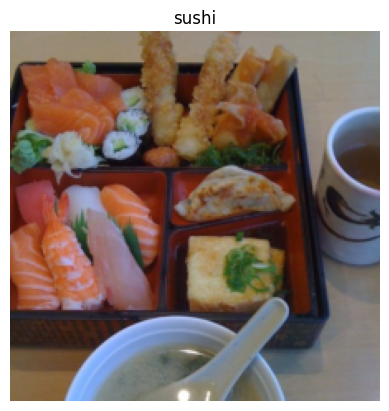

In [11]:
#@ viewing single image:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

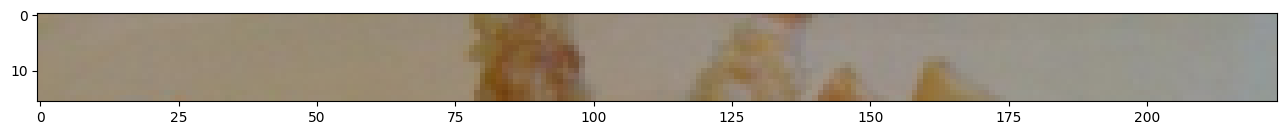

In [12]:
# changing into top row pixels:

image_permuted=image.permute(1, 2, 0)

patch_size=16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0 
 16 pixels x 16 pixels


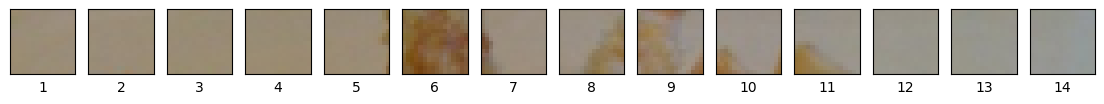

In [13]:
num_patches=img_size / patch_size
assert img_size % patch_size == 0, 'img size must be divisible by patch size'
print(f'Number of patches per row: {num_patches} \n {patch_size} pixels x {patch_size} pixels')

#@ Creating Subplots:
fig, axs= plt.subplots(nrows=1,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

### Creating Patch Embddings:


In [25]:
class PatchEmbeddings(nn.Module):
  """
  what it does?
  -> It converts 2D input image into 1D sequence learnable embedding vector

  Args:
  in_channels: no of total color of img(mainly RGB)
  patch_size: size of each patches both horizontally and vertically i.e (P, P)
  embed_dim: size of embeddings to turn image into i.e (P x P x Channel)

  """

  def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dims:int=768):
    super().__init__()

    # creating a layer to turn image into patches:
    self.patcher=nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dims,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0
                           ) # (B, E, H_p, W_p) -> Embeddings

    # creating a layer which flattens the patches into 1D vector:
    self.flatten=nn.Flatten(start_dim=2, end_dim=3) # (B, E, N) -> no of patches
            # B, C are untouched while H_p, W_p will be flattened


  def forward(self, x):
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size == 0, f"input Image size must be divisible by patch size, image shape:{image_resolution}, patch  size: {patch_size}"

    x_patched=self.patcher(x)
    x_flattened=self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1) #B, E, N -> B, N, E(P^2.C)



In [26]:
#@ Testing:
set_seeds()

# creaating instances:
patchify=PatchEmbeddings(in_channels=3,
                         patch_size=16,
                         embedding_dims=768)

print(f'Input Image shape: {image.unsqueeze(0).shape}')
patch_embedded_image=patchify(image.unsqueeze(0))
print(f'output patch embedding shape: {patch_embedded_image.shape}')

Input Image shape: torch.Size([1, 3, 224, 224])
output patch embedding shape: torch.Size([1, 196, 768])


### Creating class token embeddings:

In [28]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6045,  0.1456, -0.1552,  ...,  0.4226, -0.2783,  0.2179],
         [-0.5864,  0.1349, -0.1502,  ...,  0.4276, -0.2846,  0.2134],
         [-0.5876,  0.1259, -0.1491,  ...,  0.4234, -0.2793,  0.2121],
         ...,
         [-0.5464,  0.1408, -0.1595,  ...,  0.4066, -0.2405,  0.1650],
         [-0.5484,  0.1470, -0.1789,  ...,  0.4007, -0.2351,  0.1881],
         [-0.5917,  0.1556, -0.1756,  ...,  0.4332, -0.2443,  0.1959]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [29]:
batch_size=patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]

# creating a class token embeddings(learnable parameters):
class_token=nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

#example:
print(class_token[:, :, :10])

print(f'class token shape: {class_token.shape}')


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class token shape: torch.Size([1, 1, 768])
